In [19]:
# Install requirements  
!pip install pretty_midi torch numpy tqdm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import requirements
import os
import json
import pretty_midi
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Configuration
MIDI_DIR = r"C:\Users\Avin\Desktop\Avin\transfer\music trnasformer\maestro-v2.0.0-midi\maestro-v2.0.0"  # <-- Update this
SEQUENCE_LENGTH = 512
BATCH_SIZE = 16
EPOCHS = 20
EMBED_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 6
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Vocabulary
PAD_TOKEN = 128
EOS_TOKEN = 129
VOCAB_SIZE = 130


In [33]:
WAIT_TOKEN = 128  

In [21]:
#Convert MIDI to event sequence
def midi_to_event_sequence(file_path):
    midi = pretty_midi.PrettyMIDI(file_path)
    events = []
    for instrument in midi.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            events.append((note.start, note.pitch))
    events.sort()

    sequence = []
    prev_time = 0
    for time, pitch in events:
        wait_steps = int(round((time - prev_time) / 0.1))  # 0.1 sec resolution
        sequence += [WAIT_TOKEN] * wait_steps
        sequence.append(pitch)
        prev_time = time

    sequence = sequence[:SEQUENCE_LENGTH - 1] + [EOS_TOKEN]
    return sequence



In [22]:
#Create PyTorch Dataset
class MIDIDataset(Dataset):
    def __init__(self, midi_folder):
        self.sequences = []
        for root, _, files in os.walk(midi_folder):
            for fname in files:
                if fname.endswith(".mid") or fname.endswith(".midi"):
                    path = os.path.join(root, fname)
                    try:
                        seq = midi_to_pitch_sequence(path)
                        if len(seq) < 10:
                            continue
                        padded = seq + [PAD_TOKEN] * (SEQUENCE_LENGTH - len(seq))
                        self.sequences.append(torch.tensor(padded[:SEQUENCE_LENGTH]))
                    except:
                        continue

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx][:-1]
        y = self.sequences[idx][1:]
        return x, y


In [23]:
#Define the Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=SEQUENCE_LENGTH):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class MusicTransformer(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, d_model=EMBED_DIM, nhead=NUM_HEADS, num_layers=NUM_LAYERS):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        x = self.embedding(src) * np.sqrt(EMBED_DIM)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.decoder(x)


In [24]:
#Train the model
import matplotlib.pyplot as plt

def train():
    dataset = MIDIDataset(MIDI_DIR)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = MusicTransformer().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

    epoch_losses = []

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = loss_fn(logits.view(-1, VOCAB_SIZE), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), "music_transformer.pth")
    print("Model saved to music_transformer.pth")

    # Plot loss curve
    plt.plot(range(1, EPOCHS + 1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()



In [25]:
#Generate a music sequence
def generate(model, start_token=60, length=100):
    model.eval()
    generated = [start_token]
    for _ in range(length):
        x = torch.tensor(generated[-SEQUENCE_LENGTH+1:] + [PAD_TOKEN] * (SEQUENCE_LENGTH - len(generated) - 1)).unsqueeze(0).to(DEVICE)
        logits = model(x)
        next_token = torch.argmax(logits[0, -1]).item()
        if next_token == EOS_TOKEN or len(generated) >= SEQUENCE_LENGTH:
            break
        generated.append(next_token)
    return generated


Epoch 1/20: 100%|██████████| 81/81 [09:15<00:00,  6.86s/it]


Epoch 1, Loss: 4.1140


Epoch 2/20: 100%|██████████| 81/81 [03:33<00:00,  2.64s/it]


Epoch 2, Loss: 3.8913


Epoch 3/20: 100%|██████████| 81/81 [07:46<00:00,  5.76s/it]


Epoch 3, Loss: 3.7673


Epoch 4/20: 100%|██████████| 81/81 [18:47<00:00, 13.92s/it]


Epoch 4, Loss: 3.7324


Epoch 5/20: 100%|██████████| 81/81 [03:53<00:00,  2.88s/it]


Epoch 5, Loss: 3.7133


Epoch 6/20: 100%|██████████| 81/81 [03:36<00:00,  2.68s/it]


Epoch 6, Loss: 3.7044


Epoch 7/20: 100%|██████████| 81/81 [03:37<00:00,  2.68s/it]


Epoch 7, Loss: 3.7005


Epoch 8/20: 100%|██████████| 81/81 [03:33<00:00,  2.64s/it]


Epoch 8, Loss: 3.6924


Epoch 9/20: 100%|██████████| 81/81 [03:26<00:00,  2.55s/it]


Epoch 9, Loss: 3.6902


Epoch 10/20: 100%|██████████| 81/81 [03:26<00:00,  2.55s/it]


Epoch 10, Loss: 3.6883


Epoch 11/20: 100%|██████████| 81/81 [03:45<00:00,  2.78s/it]


Epoch 11, Loss: 3.6863


Epoch 12/20: 100%|██████████| 81/81 [03:58<00:00,  2.95s/it]


Epoch 12, Loss: 3.6819


Epoch 13/20: 100%|██████████| 81/81 [03:34<00:00,  2.65s/it]


Epoch 13, Loss: 3.6808


Epoch 14/20: 100%|██████████| 81/81 [03:36<00:00,  2.67s/it]


Epoch 14, Loss: 3.6799


Epoch 15/20: 100%|██████████| 81/81 [03:34<00:00,  2.65s/it]


Epoch 15, Loss: 3.6729


Epoch 16/20: 100%|██████████| 81/81 [03:32<00:00,  2.62s/it]


Epoch 16, Loss: 3.6721


Epoch 17/20: 100%|██████████| 81/81 [03:31<00:00,  2.61s/it]


Epoch 17, Loss: 3.6671


Epoch 18/20: 100%|██████████| 81/81 [05:20<00:00,  3.96s/it]


Epoch 18, Loss: 3.6632


Epoch 19/20: 100%|██████████| 81/81 [11:07<00:00,  8.25s/it]


Epoch 19, Loss: 3.6596


Epoch 20/20: 100%|██████████| 81/81 [03:27<00:00,  2.56s/it]


Epoch 20, Loss: 3.6613
Model saved to music_transformer.pth


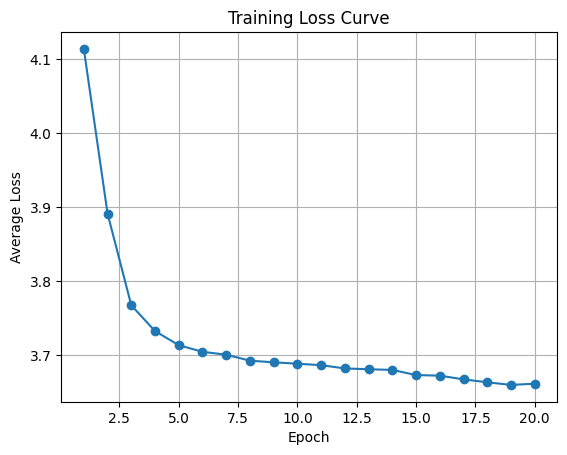

In [26]:
#Run training
train()


In [27]:
#Load the trained model
model = MusicTransformer().to(DEVICE)
model.load_state_dict(torch.load("music_transformer.pth", map_location=DEVICE))
model.eval()
print("Model loaded and ready.")


Model loaded and ready.


In [40]:
#Generate a new music sequence
'''def generate(model, start_token=60, length=200):
    model.eval()
    generated = [start_token]

    for _ in range(length):
        # Prepare input (pad left if needed)
        input_seq = generated[-SEQUENCE_LENGTH+1:]
        input_seq = input_seq + [PAD_TOKEN] * (SEQUENCE_LENGTH - len(input_seq) - 1)
        x = torch.tensor([input_seq], dtype=torch.long).to(DEVICE)

        with torch.no_grad():
            logits = model(x)
            next_token = torch.argmax(logits[0, -1]).item()

        if next_token == EOS_TOKEN:
            break

        generated.append(next_token)

    return generated'''


'def generate(model, start_token=60, length=200):\n    model.eval()\n    generated = [start_token]\n\n    for _ in range(length):\n        # Prepare input (pad left if needed)\n        input_seq = generated[-SEQUENCE_LENGTH+1:]\n        input_seq = input_seq + [PAD_TOKEN] * (SEQUENCE_LENGTH - len(input_seq) - 1)\n        x = torch.tensor([input_seq], dtype=torch.long).to(DEVICE)\n\n        with torch.no_grad():\n            logits = model(x)\n            next_token = torch.argmax(logits[0, -1]).item()\n\n        if next_token == EOS_TOKEN:\n            break\n\n        generated.append(next_token)\n\n    return generated'

In [41]:
import torch.nn.functional as F

def generate(model, start_token=60, length=200, temperature=1.0, top_k=10):
    model.eval()
    generated = [start_token]

    for _ in range(length):
        input_seq = generated[-SEQUENCE_LENGTH+1:]
        input_seq = input_seq + [PAD_TOKEN] * (SEQUENCE_LENGTH - len(input_seq) - 1)
        x = torch.tensor([input_seq], dtype=torch.long).to(DEVICE)

        with torch.no_grad():
            logits = model(x)[0, -1, :]  # (vocab_size,)
            logits = logits / temperature  # scale by temperature

            if top_k > 0:
                topk_vals, topk_idx = torch.topk(logits, top_k)
                probs = F.softmax(topk_vals, dim=0)
                next_token = topk_idx[torch.multinomial(probs, 1).item()].item()
            else:
                probs = F.softmax(logits, dim=0)
                next_token = torch.multinomial(probs, 1).item()

        if next_token == EOS_TOKEN:
            break

        generated.append(next_token)

    return generated


In [42]:
#Generate a sequence
sample = generate(model, start_token=60, length=200)
print("Generated sequence:", sample)


Generated sequence: [60, 57, 57, 70, 57, 74, 80, 74, 76, 71, 71, 69, 69, 72, 73, 71, 76, 80, 71, 69, 70, 76, 71, 80, 71, 71, 72, 70, 80, 75, 57, 69, 74, 70, 71, 70, 70, 75, 80, 73, 80, 69, 71, 71, 72, 73, 57, 70, 74, 69, 69, 76, 57, 76, 73, 80, 80, 80, 80, 76, 76, 73, 69, 69, 71, 72, 76, 80, 70, 75, 72, 80, 70, 70, 80, 70, 72, 75, 57, 57, 57, 75, 76, 73, 57, 73, 69, 73, 57, 71, 76, 74, 73, 71, 80, 76, 72, 80, 74, 69, 69, 72, 75, 76, 75, 80, 73, 57, 75, 74, 80, 71, 71, 76, 80, 74, 76, 76, 69, 76, 80, 75, 75, 80, 80, 80, 57, 76, 69, 71, 71, 72, 73, 75, 70, 71, 69, 71, 70, 74, 74, 76, 71, 57, 76, 80, 70, 76, 73, 57, 71, 70, 75, 57, 75, 80, 73, 69, 69, 73, 73, 76, 75, 73, 69, 74, 80, 57, 57, 80, 73, 80, 76, 70, 74, 80, 57, 76, 71, 80, 80, 72, 72, 80, 73, 71, 71, 80, 80, 57, 73, 80, 70, 73, 69, 76, 80, 69, 80, 76, 75]


In [43]:
#Convert to MIDI and save
def save_sequence_to_midi(sequence, file_name="generated_song.mid", wait_time=0.1, note_length=0.3):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    time = 0
    for token in sequence:
        if token == WAIT_TOKEN:
            time += wait_time
        elif 0 <= token < 128:
            note = pretty_midi.Note(velocity=100, pitch=token, start=time, end=time + note_length)
            instrument.notes.append(note)
            time += note_length
    midi.instruments.append(instrument)
    midi.write(file_name)
    print(f"MIDI file saved to {file_name}")



In [44]:
model = MusicTransformer().to(DEVICE)
model.load_state_dict(torch.load("music_transformer.pth", map_location=DEVICE))
model.eval()

sample = generate(model, start_token=60, length=200)
save_sequence_to_midi(sample, file_name="expressive_output.mid")

C:\Users\Avin\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


MIDI file saved to expressive_output.mid
